# Capacitated Vehicle Routing with Time Window

## Inizializzazione

### Librerie

In [1]:
import gurobipy as gb
from gurobipy import *
import re
from random import *
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.pyplot as plt
'''
def distance(city1, city2):
    i = coordinate[city1]
    j = coordinate[city2]
    diff = (i[0]-j[0], i[1]-j[1])
    return math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])
'''
   

plt.rcParams["figure.figsize"] = (20,10)

### Classi

In [2]:
class Node:
    def __init__(self, number, coordinate, demand, rdy_time, due_date, serv_time):
        self.number = number
        self.coordinate = coordinate
        self.demand = demand
        self.rdy_time = rdy_time
        self.due_date = due_date
        self.service_time = serv_time
    
    def distance(self, node):
        i = self.coordinate
        j = node.coordinate
        diff = (i[0]-j[0], i[1]-j[1])
        return math.sqrt(diff[0]*diff[0]+diff[1]*diff[1])
    
    def travel_time(self,node):
        return round(self.distance(node),1)

In [3]:
class CPVRTW:
    def __init__(self, file_name, num_nodes):
        self.num_nodes = num_nodes
        self.nodes = []
        f = open(file_name, "r")
        for i in range(4) :
            line = f.readline()    

        line = f.readline()
        data  = re.findall(r"[-+]?\d.\d+|\d+", line)
        self.num_vehicle = int(data[0])
        self.capacity = int(data[1])

        for i in range(4) :
            line = f.readline()    #   | Salto altre 4 linee

        for i in range(num_nodes) :
            line = f.readline()
            data = re.findall(r"[-+]?\d.\d+|\d+", line)
            coordinate = (int(data[1]), int(data[2]))
            demand = int(data[3])
            rdy_time = int(data[4])
            due_date = int(data[5])
            serv_time = int(data[6])
            self.nodes.append(Node(i,coordinate,demand,rdy_time,due_date,serv_time))
        f.close()

        self.calculate_distances()
        self.calculate_travel_times()
    
    def calculate_distances (self):
        self.distances = {(i,j): self.nodes[i].distance(self.nodes[j]) for i in range(self.num_nodes) for j in range(self.num_nodes) if i!=j}

    def calculate_travel_times(self):
        self.travel_times = {(i,j): round(self.distances[i,j],1) for i in range(self.num_nodes) for j in range(self.num_nodes) if i != j}
    
    def calculate_routes_from_model(self,x):
        node = []
        for i in range(1,self.num_nodes):
            if x[0,i]>0:
                node.append(i)

        route = []
        self.routes = []
        for k in node:
            next = k
            route.append(k)
            stop = 1
            while stop:
                for i in range(self.num_nodes):
                    if i==0 and x[next,i] == 1:
                        stop = 0
                    elif x[next,i] == 1:
                        route.append(i)
                        next = i

            self.routes.append(route)
            route = []
        

### Lettura del file e memorizzazione dei dati

$num\_nodes$  Numero di nodi <br>
$num\_vehicle$ Numero di veicoli <br>
$capacity$ Capacità di ogni veicolo (uguale per tutti) <br>
$demand_i$ Domanda di ogni cliente i da soddisfare <br>
$time\_window_i$ Finestra temporale di servizio per ogni cliente i <br>
$coordinate$ Posizione nello spazio di ogni nodo <br>
$travel\_time_{i,j}$ Tempo di percorrenza per raggiungere il cliente j partendo dal cliente i <br>
$dist_{i,j}$ Distanza euclidea tra il cliente i e il cliente j

In [4]:
file_name = "VRPTW-Instances/Solomon/C102.txt"
instance = CPVRTW(file_name, 50)

## Modellazione

### Variabili

$x_{i,j}$ Variabile binaria (1 se l'arco è attraversato da un veicolo, 0 altrimenti) <br>
$u_i$ Quantità di domanda servita dal veicolo nel percorso dal deposito al nodo i <br>
$a_i$ Tempo di arrivo nel nodo $i$

In [5]:
mod = gb.Model('CVRP')
x = mod.addVars(range(instance.num_nodes), range(instance.num_nodes),vtype=GRB.BINARY, name="X")
u = mod.addVars(range(instance.num_nodes),vtype=GRB.INTEGER, name="Y")
a = mod.addVars(range(instance.num_nodes), vtype=GRB.INTEGER,name="A")

Academic license - for non-commercial use only - expires 2021-08-10
Using license file C:\Users\Giuseppe\Universita\x\gurobi.lic


### Vincoli

Se un veicolo entra nel nodo $i$ deve anche uscirne
$$\sum_{j=0}^{n} x_{i,j} - \sum_{j=0}^{n} x_{j,i} = 0 \quad \forall i \in \{0,1,2,...,n\}$$

In [6]:
mod.addConstrs((x.sum(i,'*') - x.sum('*',i)  == 0 for i in range(instance.num_nodes)), name="Trasporto");

Dal deposito devono uscire massimo $m$ veicoli
$$\sum_{j=1}^{n} x_{0j} \leq m $$

In [7]:
mod.addConstr(x.sum(0,'*') - x[0,0] <= instance.num_vehicle, name="NumeroVeicoli");

Ogni cliente deve essere servito da un solo veicolo
$$\sum_{j=0}^{n} x_{i,j} = 1 \quad \forall  i \in \{1,2,...,n\}$$

In [8]:
mod.addConstrs((x.sum(i,'*') == 1 for i in range(1,instance.num_nodes)), name="VeicoliCliente");

Quando il camion arriva al cliente $i$, la domanda totale servita deve essere minore della sua capacità
$$u_i \leq Q \quad \forall i \in V$$ <br>
La domanda iniziale (nel nodo 0) deve essere nulla essendo il deposito
$$u_0 = 0$$

In [9]:
mod.addConstrs((u[i] <= instance.capacity for i in range(instance.num_nodes)), "CapacitàMassima");
mod.addConstr((u[0] == 0), "DomandaIniziale");

Si deve evitare di considerare archi ricorsivi (un camion entra in nodo e va nello stesso nodo)
$$x_{i,i} = 0 \quad \forall i \in {0,1,...,n}$$

In [10]:
mod.addConstrs((x[i,i] == 0 for i in range(instance.num_nodes)), "ArchiRicorsivi");

Per permettere il trasporto, dopo che il veicolo è arrivato ad un nodo si deve assicurare che può andare in quello successivo. Bisogna controllare che la richiesta del nodo successivo non supera la capacità corrente del veicolo.

$$u_j - u_i - d_jx_{i,j} + Q(1-x_{i,j}) \geq 0 \quad \forall i,j \in V, \; i\neq j, \; j \neq 0$$

In [11]:
mod.addConstrs(u[j] - u[i] - instance.nodes[j].demand*x[i,j] + instance.capacity*(1-x[i,j]) >= 0 for i in range(instance.num_nodes) for j in range(instance.num_nodes) if i!=j and j!=0);

Un veicolo può arrivare ad un nodo solo se ha completamente servito il nodo precedente
$$a_j \geq (a_i + t_i + t_{ij}) - (1-x_{ij})T \quad \forall i \in \{0,1,...,n\} \; \forall j \in \{1,2,...,n\} \; i \neq j$$
T è un tempo molto grande, si può porre pari al massimo tempo per servire tutti i nodi

In [12]:
mod.addConstrs((a[j] >= (a[i]+instance.nodes[i].service_time+instance.travel_times[i,j]) - (1-x[i,j])*instance.nodes[0].due_date for i in range(instance.num_nodes) for j in range(1,instance.num_nodes) if i!=j),name="TempiDiArrivo");
#mod.addConstrs((a[i] + travel_time[i,0] + serv_time[i] <= time_window[0][1] for i in range(1,num_nodes)),name="TempoDeposito");


Il tempo di arrivo di ogni nodo deve essere compreso nella finestra temporale
$$l_i \leq a_i \leq L_i \quad \forall i \in \{0,1,...,n\}$$

In [13]:
mod.addConstrs((a[i] >= instance.nodes[i].rdy_time for i in range(1,instance.num_nodes)),name="TW_Lower")
mod.addConstrs((a[i] <= instance.nodes[i].due_date for i in range(1,instance.num_nodes)),name="TW_Upper");

### Funzione obiettivo

Minimizzare i costi di trasporto totali
$$min \sum_{i=1}^{n}\sum_{j=1}^{n} c_{i,j}x_{i,j} \quad i \neq j$$

In [14]:
obj = (gb.quicksum(instance.distances[i,j]*x[i,j] for i in range(instance.num_nodes) for j in range(instance.num_nodes) if i!=j))
mod.setObjective(obj, GRB.MINIMIZE)

In [15]:
mod.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5101 rows, 2600 columns and 22004 nonzeros
Model fingerprint: 0xbadfce9d
Variable types: 0 continuous, 2600 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 2448 rows and 861 columns
Presolve time: 0.12s
Presolved: 2653 rows, 1739 columns, 11064 nonzeros
Variable types: 0 continuous, 1739 integer (1648 binary)

Root relaxation: objective 2.616781e+02, 267 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  311.99360    0   57          -  311.99360      -     -    0s
H    0     0                     963.0478409  311.99360  67.6%     -    0s
H    0     0

## Grafico

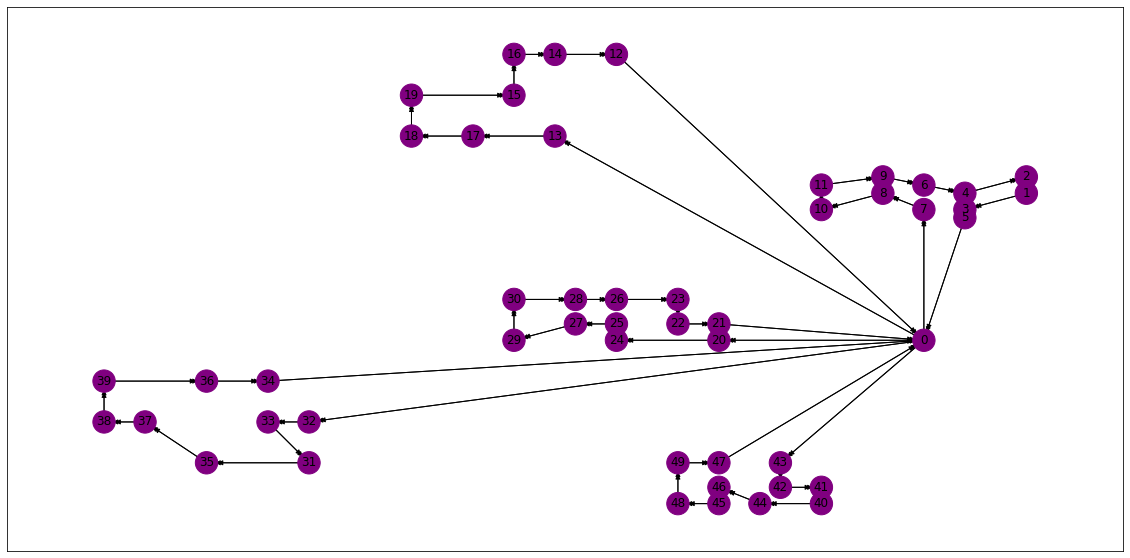

In [16]:

Graph = nx.DiGraph()
list_nodes = list(range(instance.num_nodes))
Graph.add_nodes_from(list_nodes)
for i in range(instance.num_nodes):
    for j in range(instance.num_nodes) :
        if i!=j and x[i,j].x == 1 :
            Graph.add_edge(i,j)

dict_dem = {}
for i in range(instance.num_nodes) :
    dict_dem[i] = instance.nodes[i].demand
coordinate = {}
for i in range(instance.num_nodes):
     coordinate[i] = instance.nodes[i].coordinate
# Colora di rosso i nodi della soluzione e di verde gli altri
node_col = ['purple' for node in Graph.nodes()]
# Colora di rosso gli archi della soluzione e di nero gli altri
edge_col = ['black' for edge in Graph.edges()]
# Draw the nodes
nx.draw_networkx(Graph,coordinate, node_color= node_col, node_size=500)
# Draw the edges
nx.draw_networkx_edges(Graph, coordinate,edge_color= edge_col)
# Show the plot
#nx.draw_networkx_labels(Graph,coordinate,labels= dict_dem,horizontalalignment='center',verticalalignment='bottom')

plt.show()

In [17]:
X = mod.getAttr('x', x)
instance.calculate_routes_from_model(X)
for i in range(len(instance.routes)) :
    print(instance.routes[i])    

[7, 8, 10, 11, 9, 6, 4, 2, 1, 3, 5]
[13, 17, 18, 19, 15, 16, 14, 12]
[20, 24, 25, 27, 29, 30, 28, 26, 23, 22, 21]
[32, 33, 31, 35, 37, 38, 39, 36, 34]
[43, 42, 41, 40, 44, 46, 45, 48, 49, 47]


----------------------------------------------------------------------------------------------------------------------